# Math Behind Attention

We implement the math behind the attention mechanism mentioned in *Attention Is All You Need* : https://arxiv.org/abs/1706.03762

There are two parts:

1. Attention with custom input embeddings (simple and small vectors). 
2. Attention with Word2vec embeddings.

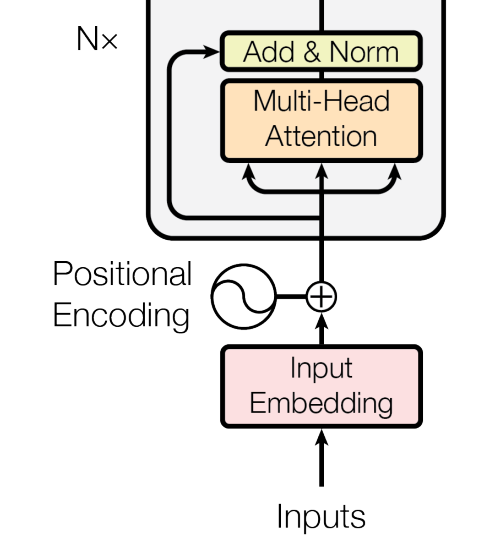

We implement this part of the transformer's architecture from https://arxiv.org/pdf/1706.03762.pdf

In the first part, we simply define the input embeddings (vectors) manually. This is a simple approach just to carry out the math and write functions for reusability for future dense vectors (second part). The input embeddings are then introduced to positional encodings that preserve the position information of tokens in the input. The addition of positional encodings to input embeddings results to positional embeddings that act as input to the attention sub-layer. Inside the attention layer, each input is represented by Q, K, and V vectors (matrices) of model's dimension. Attention is calculated using the formula mentioned below that outputs a matrix containing values for each token with preserved model dimensions.

While in the second part, we write a simple sentence and generate its Word2Vec embeddings of dimension 224. These embeddings then go through positional encoding, eventually, leading to the generation of positional embeddings. Then, attention is calculated using multi-head attention mechanism. The positional embeddings of dimension 224 are divided into heads of 56 dimension. The output from all 4 heads, which is in dimension 56, is concatenated to form result of model dimension 224. This result is then normalised using the Post- Layer Norm method.

https://www.amazon.co.uk/Transformers-Natural-Language-Processing-architectures/dp/1803247339

# Attention Mechanism with custom input embedding

In [194]:
import numpy as np
from scipy.special import softmax

## Input Embedding

In [195]:
# These are the word embeddings of only 3 tokens with their positions in input
inp_emb1, pos1 = np.array([1,2,3,4]), 1
inp_emb2, pos2 = np.array([4,5,2,3]), 2
inp_emb3, pos3 = np.array([6,1,2,2]), 3

In [196]:
# The dimension for model is 4, for simplicity.
dim_model = 4

## Positional Encoding

$$PE(pos_{2i}) = \sin\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)

$$PE(pos_{2i+1}) = \cos\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)

transformed word embedding: $$y_1 \cdot \sqrt{d_{\text{model}}}$$

In [371]:
def positional_encoding(inp_emb, pos):
    """
    This function outputs the positional embedding of the inputs.
    It first calculates the positional encoding for each input using
    sin and cos functions. Then, adds the positional encoding to a
    transformed word embedding.
    The transformed word embedding is used to retain the word embedding 
    info without being minimised by position information.
    """
    pos_enc = [0]*dim_model

    for i in range(0, dim_model-1, 2):
        term = pos/(10000**((2*i)/dim_model))
        pos_enc[i] = np.sin(term)
        pos_enc[i+1] = np.cos(term)

        transformed_word_emb = inp_emb*np.sqrt(dim_model)
        pos_enc[i] = pos_enc[i] + transformed_word_emb[i]
        pos_enc[i+1] = pos_enc[i+1] + transformed_word_emb[i+1]

    
    return pos_enc

In [198]:
pos_enc1 = positional_encoding(inp_emb1, pos1)
pos_enc2 = positional_encoding(inp_emb2, pos2)
pos_enc3 = positional_encoding(inp_emb3, pos3)

In [199]:
pos_enc1

[2.8414709848078967, 4.54030230586814, 6.000099999999834, 8.999999995]

In [200]:
pos_enc2

[8.909297426825681, 9.583853163452858, 4.000199999998666, 6.99999998]

In [201]:
pos_enc3

[12.141120008059866, 1.0100075033995546, 4.0002999999955, 4.999999955000001]

## Attention Layer

In [202]:
attention_input = np.array([pos_enc1, pos_enc2, pos_enc3])

In [203]:
attention_input

array([[ 2.84147098,  4.54030231,  6.0001    ,  8.99999999],
       [ 8.90929743,  9.58385316,  4.0002    ,  6.99999998],
       [12.14112001,  1.0100075 ,  4.0003    ,  4.99999996]])

Inside attention mechanism, each word vector has 3 representations: A query vector (Q), A key vector (K), and a value vector (V). Here,

Q = attention_input x W_Q

K = attention_input x W_K

V = attention_input x W_V

Q, K, and V are obtained from matrix multiplication of wight matrices and input matrix. Here, W_Q, W_K, W_V  are the weights of Query, Key, and Value respectively, and these weight matrices are learnt and updated during training.

Here, We use the initialsed values of these weight vectors.

In [357]:
# for future matrix multiplication the number of columns in first
#  matrix should be equal to the number of rows of the second matrix.
dim_model = 4
np.random.seed(12)
def initialise_weights(dim,n):
    W_Q = np.random.randint(n, size = (dim, dim))
    W_K= np.random.randint(n, size = (dim, dim))
    W_V = np.random.randint(n, size = (dim, dim))
    return W_Q, W_K, W_V

In [358]:
W_Q, W_K, W_V = initialise_weights(dim_model,5)

In [359]:
W_Q

array([[3, 3, 1, 2],
       [3, 3, 4, 0],
       [1, 4, 1, 2],
       [3, 2, 0, 0]])

In [360]:
W_K

array([[4, 2, 1, 3],
       [4, 3, 1, 0],
       [2, 2, 0, 4],
       [3, 1, 0, 0]])

In [361]:
W_V

array([[3, 3, 1, 3],
       [0, 1, 1, 0],
       [4, 0, 4, 1],
       [3, 4, 3, 3]])

In [362]:
Q = np.matmul(attention_input, W_Q)
K = np.matmul(attention_input, W_K)
V = np.matmul(attention_input, W_V)

In [363]:
Q

array([[55.14541986, 64.14571986, 27.00278021, 17.68314197],
       [80.47965171, 85.48025173, 51.24491008, 25.81899485],
       [58.4536824 , 65.45458244, 20.18145002, 32.28284002]])

In [364]:
K

array([[ 68.52729315,  40.30404888,   7.38177329,  32.52481295],
       [102.9730023 ,  61.57055432,  18.49315059,  42.72869228],
       [ 75.60510991,  40.31286248,  13.15112751,  52.42456002]])

In [365]:
V

array([[59.52481294, 49.06471524, 58.38217328, 41.52451294],
       [63.72869222, 64.31174536, 55.49395053, 51.72809222],
       [67.42455989, 57.43336735, 44.15232738, 55.42365989]])

### Calculating Attention

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V$$


In [300]:
def attention(Q,K,V, dim):
    Q_againt_Kvalues = np.matmul(Q, K.T) / np.sqrt(dim)
    softmax_score = softmax(Q_againt_Kvalues)
    final_attention = np.matmul(softmax_score, V)
    return final_attention
    
     

In [302]:
# here, dim_k = dim_model
attention(Q,K,V, dim_model)

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [63.72869222, 64.31174536, 55.49395053, 51.72809222],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

The first row of the output matrix pertains to the first input word, the second row corresponds to the second word, and so on. The 4 columns pertain to the dimensions of the model. Just like word embeddings have dimensions, attention matrix also have dimensions. The values inside this matrix signifies the amount of attention needs to be paid for a particular input (row) in that particular dimension (column).

# Attention mechanism using Word2Vec embeddings

In [303]:
sentence = "The big cat sat on the mat."

In [342]:
from gensim.models import Word2Vec

In [341]:
sentence = "The big cat sat on the mat"
data = sentence.lower().split()
data

['the', 'big', 'cat', 'sat', 'on', 'the', 'mat']

In [384]:
# using CBOW 
model = Word2Vec([data], min_count=1, vector_size=224, window=2)

embedding_dict = {}
for word in data:
    embedding_dict[word] = model.wv[word]

In [385]:
input_embeddings = np.array([
    embedding_dict[word] for word in data
])

In [386]:
input_embeddings.shape

(7, 224)

In [387]:
dim_model = 224
# pe = []*input_embeddings.shape[0]
pe = [positional_encoding(input_embeddings[i], i+1) for i in range(input_embeddings.shape[0])]
pe = np.array(pe)

In [388]:
pe.shape

(7, 224)

We're going to implement multi-head attention - with 4 heads (or 4 iterations in our case) and head dimension as 56.

In [415]:
W_Q, W_K, W_V = initialise_weights(56, 5)

In [416]:
W_Q.shape

(56, 56)

In [417]:
attention_inputs = []*4

In [419]:
input_embeddings.shape

(7, 224)

In [420]:
dim_head = 56
i = 0
inputs_for_heads = [[]]*4
for n in range(0,224,dim_head):
    head_input = np.array([input_embed[n:n+56] for input_embed in input_embeddings])
    # break
    inputs_for_heads[i] = head_input
    i += 1


In [421]:
np.array(inputs_for_heads).shape

(4, 7, 56)

In [422]:
Q = [[]] * 4
K = [[]] * 4
V = [[]] * 4

In [437]:
dim_head = 56
attention_outputs_from_heads = [[]]*4
i = 0
for head_input in inputs_for_heads:
    Q = np.matmul(head_input, W_Q)
    K = np.matmul(head_input, W_K)
    V = np.matmul(head_input, W_V)

    head_attention_output = attention(Q,K,V, dim_head)
    attention_outputs_from_heads[i] = head_attention_output
    i += 1
attention_outputs_from_heads = np.array(attention_outputs_from_heads)

In [438]:
attention_outputs_from_heads.shape

(4, 7, 56)

In [446]:
final_attention = np.hstack(attention_outputs_from_heads)

In [449]:
final_attention.shape

(7, 224)

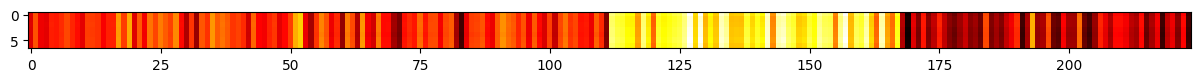

In [451]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
plt.imshow(final_attention, cmap='hot')